# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:29<00:00, 2.04KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

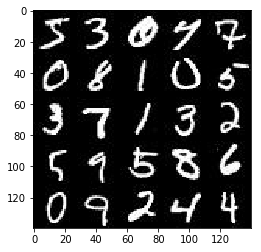

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

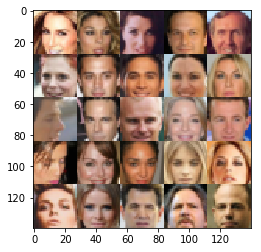

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/Users/trdelgado/anaconda/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.05
        
        # Input convolutional layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        # Leaky Relu activation
        x1 = tf.maximum(alpha*x1, x1)
        
        # Second convolutional layer
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        # Batch normalization
        x2 = tf.layers.batch_normalization(x2, training=True)
        # Leaky Relu activation
        x2 = tf.maximum(alpha*x2, x2)
        
        # Third convolutional layer
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        # Batch normalization
        x3 = tf.layers.batch_normalization(x3, training=True)
        # Leaky Relu activation
        x3 = tf.maximum(alpha*x3, x3)
        
        # Reshape stack
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse = not is_train):
        alpha = 0.05
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        # Batch normalization
        x1 = tf.layers.batch_normalization(x1, training=True)
        # Leaky Relu activation
        x1 = tf.maximum(alpha * x1, x1) # 4x4x512
        
        # Convolutional layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        # Batch normalization
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # Leaky Relu activation
        x2 = tf.maximum(alpha * x2, x2) # 7x7x256
        
        # 2nd Convoutional layer
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        # Batch normalization
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # Leaky Relu activation
        x3 = tf.maximum(alpha * x3, x3) # 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same') # 28x28x3
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Smoothing to help the discriminator generalize better
    smooth = 0.1
    
    # Get generator and discriminator outputs
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    # Get the fake and real discriminator loss and add them to get the total discriminator loss
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_model_real) * (1 - smooth)))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    
    # Get the generator loss
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    # Optimize
    # The weights should be same for both real and fake data so we need to reuse the variables
    # Where the generator's and the discriminator's update ops are clearly distinguished
    # Source: https://discussions.udacity.com/t/project-5-net-not-training/246936/9
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Get data shape and model inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
                
    # Get the loss values from the generator and discriminator
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # Get the generator and discriminator optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2.0
                
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate}) # Run generator twice to learn faster than discriminator
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs), \
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:  
                    # Output the images generated so far
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                          
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 4.8091
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 2.7356
Epoch 1/1... Discriminator Loss: 2.4008... Generator Loss: 0.1969
Epoch 1/1... Discriminator Loss: 1.9202... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 2.1194... Generator Loss: 0.2370
Epoch 1/1... Discriminator Loss: 2.3259... Generator Loss: 0.1821
Epoch 1/1... Discriminator Loss: 2.1899... Generator Loss: 0.2098
Epoch 1/1... Discriminator Loss: 1.8695... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.6719... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.5711


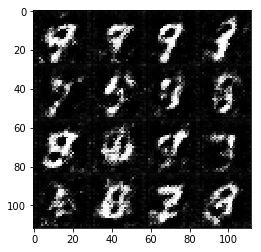

Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 1.0426


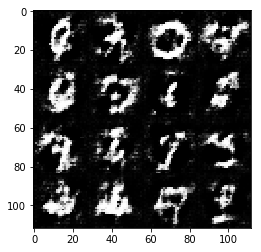

Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.6753... Generator Loss: 0.4016
Epoch 1/1... Discriminator Loss: 1.9181... Generator Loss: 0.2848
Epoch 1/1... Discriminator Loss: 1.9273... Generator Loss: 0.2606
Epoch 1/1... Discriminator Loss: 2.0109... Generator Loss: 0.2322
Epoch 1/1... Discriminator Loss: 1.9035... Generator Loss: 0.2660
Epoch 1/1... Discriminator Loss: 1.9498... Generator Loss: 0.2618
Epoch 1/1... Discriminator Loss: 1.7285... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 1.6444... Generator Loss: 0.4890


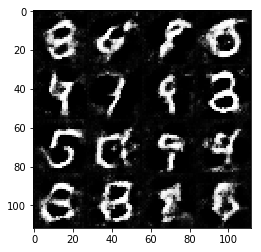

Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.8245... Generator Loss: 0.3031
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.9153... Generator Loss: 0.2767
Epoch 1/1... Discriminator Loss: 1.8800... Generator Loss: 0.2777
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.8288... Generator Loss: 0.3127
Epoch 1/1... Discriminator Loss: 1.6054... Generator Loss: 0.4206


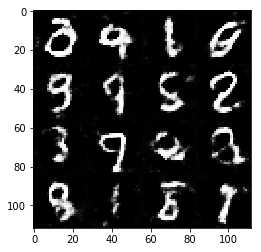

Epoch 1/1... Discriminator Loss: 1.6460... Generator Loss: 0.3911
Epoch 1/1... Discriminator Loss: 1.7813... Generator Loss: 0.3167
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.6183... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.4541
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 1.1013


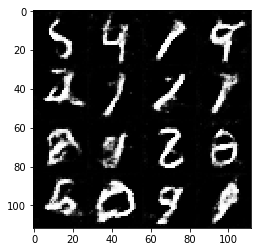

Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 2.0657... Generator Loss: 0.2165
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 1.6538... Generator Loss: 0.3812
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8317


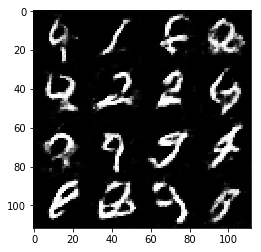

Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.7917... Generator Loss: 0.2946
Epoch 1/1... Discriminator Loss: 1.6780... Generator Loss: 0.3764
Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 1.7187... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 1.9517... Generator Loss: 0.2559
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.5865


Epoch 1/1... Discriminator Loss: 2.0120... Generator Loss: 0.2454
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.7098... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.6686... Generator Loss: 0.4163


Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.9012... Generator Loss: 0.2776
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.8047


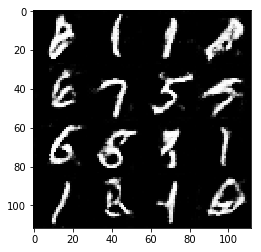

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.7089


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 2.9553... Generator Loss: 0.1014
Epoch 1/2... Discriminator Loss: 3.6297... Generator Loss: 0.0421
Epoch 1/2... Discriminator Loss: 2.6615... Generator Loss: 0.1471
Epoch 1/2... Discriminator Loss: 2.9523... Generator Loss: 0.1134
Epoch 1/2... Discriminator Loss: 2.4223... Generator Loss: 0.1776
Epoch 1/2... Discriminator Loss: 2.2623... Generator Loss: 0.1992
Epoch 1/2... Discriminator Loss: 2.2892... Generator Loss: 0.1870
Epoch 1/2... Discriminator Loss: 1.8889... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 1.5321... Generator Loss: 1.5614
Epoch 1/2... Discriminator Loss: 2.0076... Generator Loss: 0.3084


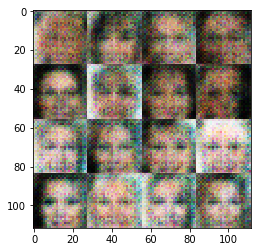

Epoch 1/2... Discriminator Loss: 2.0130... Generator Loss: 0.4191
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 1.2058
Epoch 1/2... Discriminator Loss: 1.7336... Generator Loss: 0.4163
Epoch 1/2... Discriminator Loss: 2.1426... Generator Loss: 0.2209
Epoch 1/2... Discriminator Loss: 2.0467... Generator Loss: 0.2500
Epoch 1/2... Discriminator Loss: 2.2232... Generator Loss: 0.1913
Epoch 1/2... Discriminator Loss: 1.9070... Generator Loss: 0.3534
Epoch 1/2... Discriminator Loss: 1.9995... Generator Loss: 0.2834
Epoch 1/2... Discriminator Loss: 1.7377... Generator Loss: 0.5558
Epoch 1/2... Discriminator Loss: 1.7592... Generator Loss: 0.4335


Epoch 1/2... Discriminator Loss: 1.7380... Generator Loss: 0.5886
Epoch 1/2... Discriminator Loss: 1.6149... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.6422... Generator Loss: 0.5961
Epoch 1/2... Discriminator Loss: 1.7576... Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 1.7833... Generator Loss: 0.3801
Epoch 1/2... Discriminator Loss: 1.6856... Generator Loss: 0.4488
Epoch 1/2... Discriminator Loss: 1.5310... Generator Loss: 0.6013
Epoch 1/2... Discriminator Loss: 1.6383... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.5797... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 1.5540... Generator Loss: 0.6509


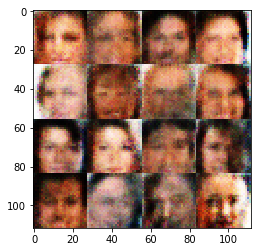

Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.6807
Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.7080
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.7134
Epoch 1/2... Discriminator Loss: 1.6020... Generator Loss: 0.5647
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 1.5995... Generator Loss: 0.4642
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 1.5706... Generator Loss: 0.6520
Epoch 1/2... Discriminator Loss: 1.5040... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 1.5260... Generator Loss: 0.7207


Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.5874
Epoch 1/2... Discriminator Loss: 1.4981... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 1.5832... Generator Loss: 0.5779
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.5720
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 1.5628... Generator Loss: 0.5948
Epoch 1/2... Discriminator Loss: 1.5242... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 1.5375... Generator Loss: 0.5941
Epoch 1/2... Discriminator Loss: 1.5034... Generator Loss: 0.7031
Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 0.6518


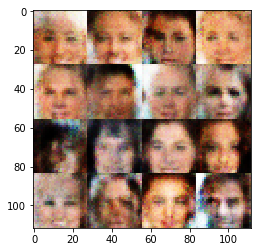

Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 1.5196... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 1.4672... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.5088... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 0.5886
Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.6479


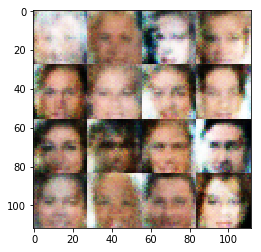

Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.6475
Epoch 1/2... Discriminator Loss: 1.5019... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.4868... Generator Loss: 0.6789
Epoch 1/2... Discriminator Loss: 1.4625... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 1.5008... Generator Loss: 0.7806
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.7446
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.5697
Epoch 1/2... Discriminator Loss: 1.4376... Generator Loss: 0.8575
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.8017


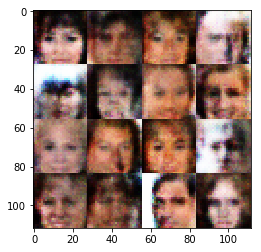

Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 0.9559
Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 1.3735
Epoch 1/2... Discriminator Loss: 1.4293... Generator Loss: 1.0899
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.8341
Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 1.3501
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.9844
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 1.1129
Epoch 1/2... Discriminator Loss: 1.5446... Generator Loss: 0.4926


Epoch 1/2... Discriminator Loss: 1.6552... Generator Loss: 0.3790
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 1.5751... Generator Loss: 0.4325
Epoch 1/2... Discriminator Loss: 1.5323... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 1.5235... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.9932
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.9589
Epoch 1/2... Discriminator Loss: 1.4657... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 1.5341... Generator Loss: 0.6031


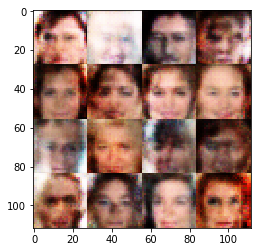

Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.8997
Epoch 1/2... Discriminator Loss: 1.4924... Generator Loss: 0.5779
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.9958
Epoch 1/2... Discriminator Loss: 1.4927... Generator Loss: 0.5566
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 0.5962
Epoch 1/2... Discriminator Loss: 1.5537... Generator Loss: 0.4791
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.7500
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 0.6508
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.5703


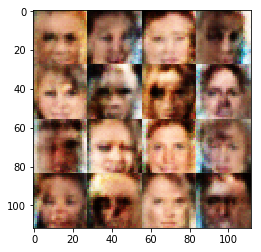

Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 0.5962
Epoch 1/2... Discriminator Loss: 1.5554... Generator Loss: 0.5139
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.5114
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.8187
Epoch 1/2... Discriminator Loss: 1.5178... Generator Loss: 0.5446
Epoch 1/2... Discriminator Loss: 1.4807... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.4495... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.6594
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.7655


Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.7284
Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 1.0643
Epoch 1/2... Discriminator Loss: 1.4519... Generator Loss: 0.6562
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.6933
Epoch 1/2... Discriminator Loss: 1.4460... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 1.5852... Generator Loss: 0.4735
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.6945
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.4545... Generator Loss: 0.6872


Epoch 1/2... Discriminator Loss: 1.4341... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.6302
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.4716... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.8722
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.7755
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 1.1146
Epoch 1/2... Discriminator Loss: 1.4444... Generator Loss: 0.7254


Epoch 1/2... Discriminator Loss: 1.4974... Generator Loss: 0.5829
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.6680
Epoch 1/2... Discriminator Loss: 1.4586... Generator Loss: 0.7309
Epoch 1/2... Discriminator Loss: 1.4665... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.8435
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.9436
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.8269
Epoch 1/2... Discriminator Loss: 1.4632... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.6332


Epoch 1/2... Discriminator Loss: 1.4504... Generator Loss: 0.7167
Epoch 1/2... Discriminator Loss: 1.4771... Generator Loss: 0.6539
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.8957
Epoch 1/2... Discriminator Loss: 1.5697... Generator Loss: 0.4913
Epoch 1/2... Discriminator Loss: 1.5423... Generator Loss: 0.4899
Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.4689... Generator Loss: 0.6617
Epoch 1/2... Discriminator Loss: 1.5349... Generator Loss: 0.4948
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.7264
Epoch 1/2... Discriminator Loss: 1.4863... Generator Loss: 0.6365


Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.8811
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.6418
Epoch 1/2... Discriminator Loss: 1.5217... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.5175... Generator Loss: 0.7076
Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 0.7489


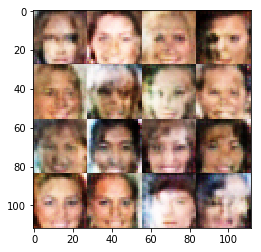

Epoch 1/2... Discriminator Loss: 1.5363... Generator Loss: 0.6520
Epoch 1/2... Discriminator Loss: 1.4233... Generator Loss: 0.7729
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.5831... Generator Loss: 0.4896
Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.5302... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 0.9598
Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.4816
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 0.9886


Epoch 1/2... Discriminator Loss: 1.4666... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.6902
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 1.4911... Generator Loss: 0.6564
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 0.6766
Epoch 1/2... Discriminator Loss: 1.4718... Generator Loss: 0.7045
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 0.5691
Epoch 1/2... Discriminator Loss: 1.4833... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.7545


Epoch 1/2... Discriminator Loss: 1.4638... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 1.5772... Generator Loss: 0.5336
Epoch 1/2... Discriminator Loss: 1.4901... Generator Loss: 0.6199
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 1.4918... Generator Loss: 0.6135
Epoch 1/2... Discriminator Loss: 1.4769... Generator Loss: 0.5924
Epoch 1/2... Discriminator Loss: 1.5265... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 1.5619... Generator Loss: 0.5248
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.7566


Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.6465
Epoch 1/2... Discriminator Loss: 1.5137... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 1.5496... Generator Loss: 0.6061
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.7852
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.6799
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.7077


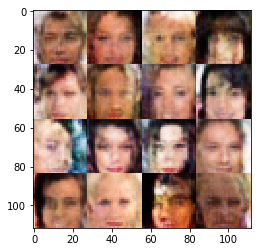

Epoch 1/2... Discriminator Loss: 1.4783... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 0.6803
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 1.4723... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.8143
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 1.4246... Generator Loss: 0.6584
Epoch 1/2... Discriminator Loss: 1.5733... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 1.5432... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.4587... Generator Loss: 0.7109


Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.8020
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.7611
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.6685
Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 0.7720
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.7506
Epoch 1/2... Discriminator Loss: 1.4757... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.4732... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 1.4710... Generator Loss: 0.6807


Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 0.6747
Epoch 1/2... Discriminator Loss: 1.4579... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.7086
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.6297
Epoch 1/2... Discriminator Loss: 1.4502... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.8680
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.7585


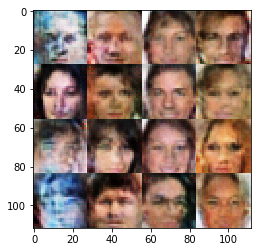

Epoch 1/2... Discriminator Loss: 1.4918... Generator Loss: 0.7188
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.6418
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.7174
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.6807
Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.4864... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 1.4597... Generator Loss: 0.6852


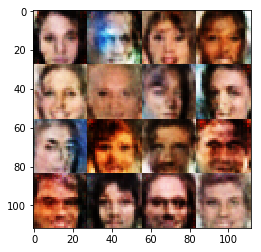

Epoch 1/2... Discriminator Loss: 1.4841... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.7554
Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.6433
Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 0.6747
Epoch 1/2... Discriminator Loss: 1.4693... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 1.5316... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.6681
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.6021


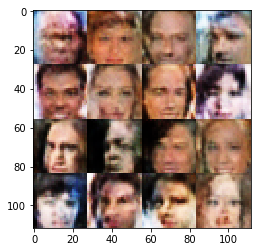

Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.7520
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.8139
Epoch 1/2... Discriminator Loss: 1.4639... Generator Loss: 0.6888
Epoch 1/2... Discriminator Loss: 1.4785... Generator Loss: 0.6243
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.6933
Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.6548
Epoch 1/2... Discriminator Loss: 1.4313... Generator Loss: 0.6760
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 1.4631... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.7044


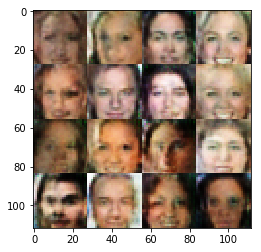

Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.6474
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.6372
Epoch 1/2... Discriminator Loss: 1.4665... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 0.7096
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.6703
Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 0.7072
Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.6833
Epoch 1/2... Discriminator Loss: 1.4793... Generator Loss: 0.6540
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 0.7624


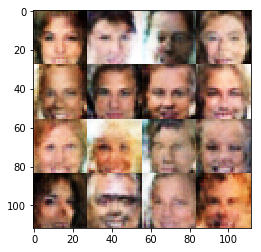

Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.6635
Epoch 1/2... Discriminator Loss: 1.4751... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.6431
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.6430
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 0.7750


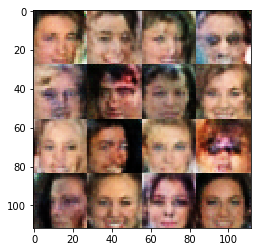

Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.4073... Generator Loss: 0.7265
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.6844
Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.4410... Generator Loss: 0.7226
Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.6551
Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 0.6524


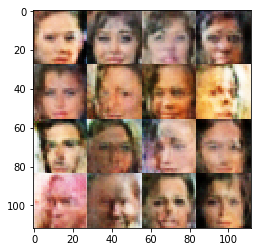

Epoch 1/2... Discriminator Loss: 1.4474... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 0.6942
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 0.6722
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.7079
Epoch 1/2... Discriminator Loss: 1.4492... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.4411... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.4639... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.6896


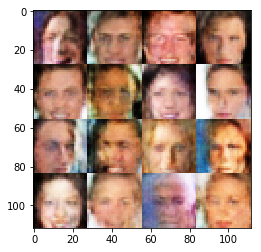

Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.4802... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 1.4558... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.4592... Generator Loss: 0.6613
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.7767
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.4411... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.4404... Generator Loss: 0.7393


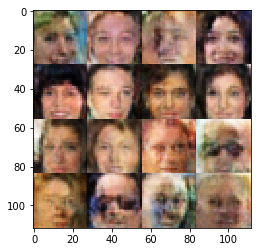

Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 0.6526
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 0.7389
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 1.4710... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 1.4499... Generator Loss: 0.7064
Epoch 2/2... Discriminator Loss: 1.4830... Generator Loss: 0.6739
Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.6715


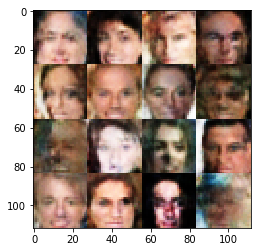

Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 0.7579
Epoch 2/2... Discriminator Loss: 1.4205... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 1.4630... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 1.4569... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.7146
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.4325... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.4275... Generator Loss: 0.7292


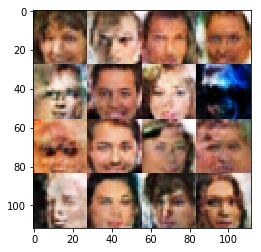

Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 1.4268... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 1.4647... Generator Loss: 0.6766
Epoch 2/2... Discriminator Loss: 1.4491... Generator Loss: 0.6594
Epoch 2/2... Discriminator Loss: 1.4617... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.4434... Generator Loss: 0.7188
Epoch 2/2... Discriminator Loss: 1.4217... Generator Loss: 0.7830
Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.7174
Epoch 2/2... Discriminator Loss: 1.4418... Generator Loss: 0.7770


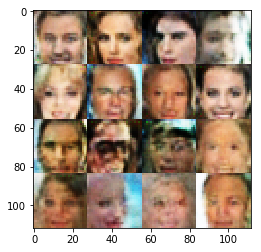

Epoch 2/2... Discriminator Loss: 1.4490... Generator Loss: 0.7266
Epoch 2/2... Discriminator Loss: 1.4259... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.4113... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 1.4451... Generator Loss: 0.6808
Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 1.4473... Generator Loss: 0.6698
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.7521
Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.6738


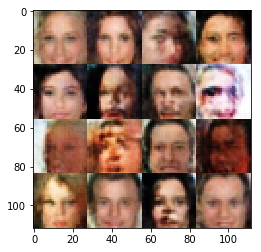

Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 1.4781... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 0.7366
Epoch 2/2... Discriminator Loss: 1.4639... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.7521
Epoch 2/2... Discriminator Loss: 1.4507... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.4554... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 1.4299... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.4076... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 1.4119... Generator Loss: 0.7646


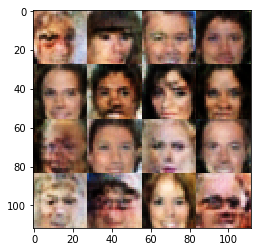

Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 0.6251
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.7534
Epoch 2/2... Discriminator Loss: 1.4330... Generator Loss: 0.6696
Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 1.4318... Generator Loss: 0.7126
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.7823


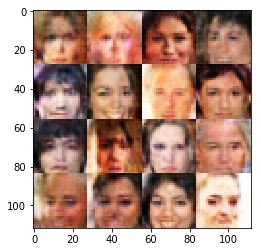

Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.7721
Epoch 2/2... Discriminator Loss: 1.4358... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.4372... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 1.4384... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 1.4649... Generator Loss: 0.6646
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.7478
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.4645... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.4590... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 0.8355


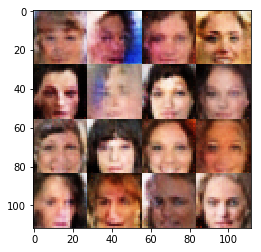

Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.4308... Generator Loss: 0.7600
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.7940
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.7256
Epoch 2/2... Discriminator Loss: 1.4637... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.7282


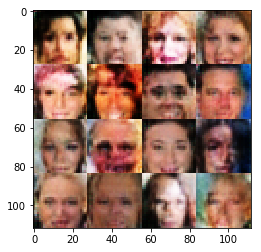

Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.4569... Generator Loss: 0.6614
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.9046
Epoch 2/2... Discriminator Loss: 1.4502... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.7789
Epoch 2/2... Discriminator Loss: 1.4576... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 1.4225... Generator Loss: 0.7689
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.7569


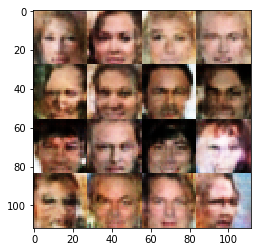

Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.7643
Epoch 2/2... Discriminator Loss: 1.4813... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.4490... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.4274... Generator Loss: 0.7545
Epoch 2/2... Discriminator Loss: 1.4448... Generator Loss: 0.7652
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.4178... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.8140


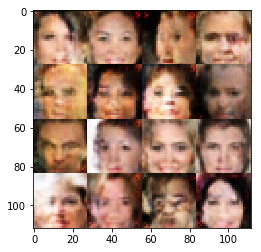

Epoch 2/2... Discriminator Loss: 1.4715... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 1.4567... Generator Loss: 0.6482
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.8389
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.9225
Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 0.7569
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.6754
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.7309
Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 0.7346


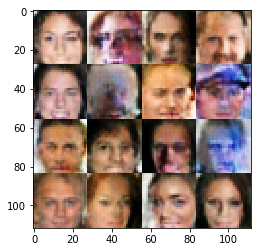

Epoch 2/2... Discriminator Loss: 1.4308... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 1.4346... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.4251... Generator Loss: 0.7537
Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.4201... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.7578
Epoch 2/2... Discriminator Loss: 1.4712... Generator Loss: 0.6578
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.7857


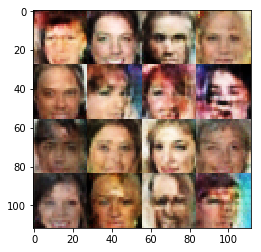

Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.7104
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.7828
Epoch 2/2... Discriminator Loss: 1.4279... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.6925


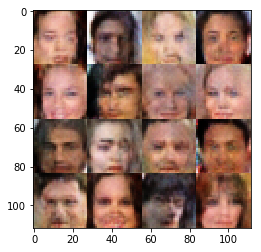

Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 1.4321... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.4501... Generator Loss: 0.6852
Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.4115... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.4220... Generator Loss: 0.6878


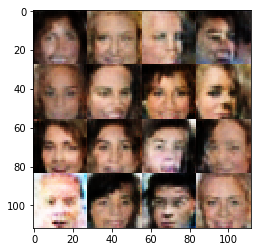

Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 1.4463... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 1.4164... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.4225... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 1.4259... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.4370... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.4179... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.7083


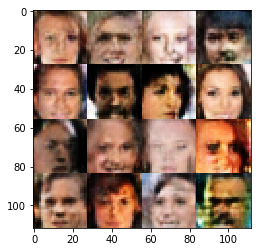

Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.8472
Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.4099... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.7370


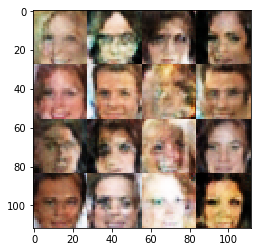

Epoch 2/2... Discriminator Loss: 1.4119... Generator Loss: 0.7637
Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.6789
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 0.6613
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.6820
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 1.4312... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.7263


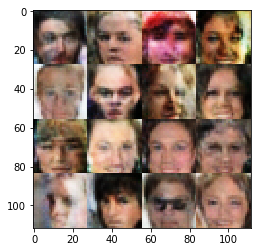

Epoch 2/2... Discriminator Loss: 1.4634... Generator Loss: 0.6970
Epoch 2/2... Discriminator Loss: 1.4187... Generator Loss: 0.7470
Epoch 2/2... Discriminator Loss: 1.4393... Generator Loss: 0.6775
Epoch 2/2... Discriminator Loss: 1.4073... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.6965


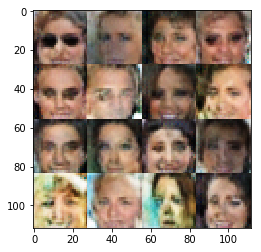

Epoch 2/2... Discriminator Loss: 1.4494... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 1.4377... Generator Loss: 0.6986
Epoch 2/2... Discriminator Loss: 1.4381... Generator Loss: 0.7160
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.4133... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 1.4115... Generator Loss: 0.7325
Epoch 2/2... Discriminator Loss: 1.4189... Generator Loss: 0.7097


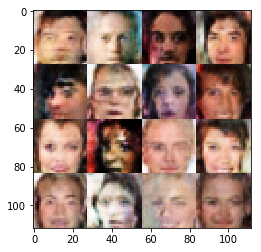

Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.4405... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.4203... Generator Loss: 0.7342
Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 0.6586
Epoch 2/2... Discriminator Loss: 1.4578... Generator Loss: 0.7124
Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 0.7147
Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 1.4339... Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.4299... Generator Loss: 0.7186
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.7374


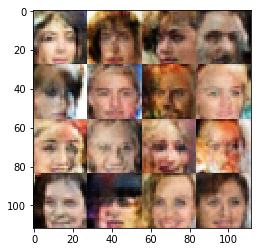

Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.4557... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.6510
Epoch 2/2... Discriminator Loss: 1.4432... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 1.4400... Generator Loss: 0.6436
Epoch 2/2... Discriminator Loss: 1.3998... Generator Loss: 0.7308
Epoch 2/2... Discriminator Loss: 1.4109... Generator Loss: 0.7686


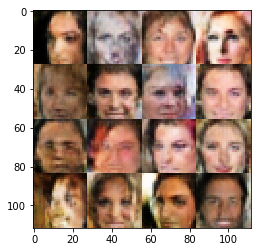

Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.7199
Epoch 2/2... Discriminator Loss: 1.4382... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 1.4094... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.6501
Epoch 2/2... Discriminator Loss: 1.4610... Generator Loss: 0.6536
Epoch 2/2... Discriminator Loss: 1.4089... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.7305


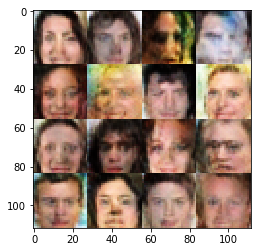

Epoch 2/2... Discriminator Loss: 1.4603... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 0.7087
Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 0.7895
Epoch 2/2... Discriminator Loss: 1.4506... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 1.4345... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.4375... Generator Loss: 0.7040
Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.8122


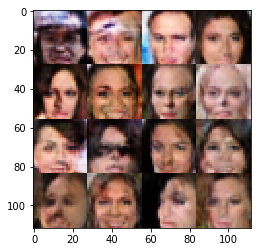

Epoch 2/2... Discriminator Loss: 1.4469... Generator Loss: 0.6811
Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.4193... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 0.8091
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 1.4205... Generator Loss: 0.6384
Epoch 2/2... Discriminator Loss: 1.4285... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.7045
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.6830


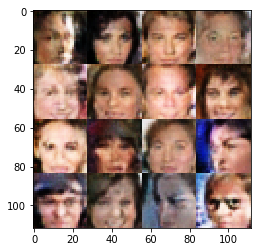

Epoch 2/2... Discriminator Loss: 1.4286... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 0.7214
Epoch 2/2... Discriminator Loss: 1.4262... Generator Loss: 0.7530
Epoch 2/2... Discriminator Loss: 1.4283... Generator Loss: 0.7243
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.7286
Epoch 2/2... Discriminator Loss: 1.3970... Generator Loss: 0.7790
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 0.7389
Epoch 2/2... Discriminator Loss: 1.4267... Generator Loss: 0.6825


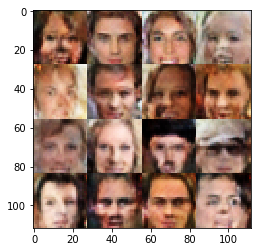

Epoch 2/2... Discriminator Loss: 1.4148... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 1.4294... Generator Loss: 0.7431
Epoch 2/2... Discriminator Loss: 1.4143... Generator Loss: 0.7706
Epoch 2/2... Discriminator Loss: 1.4187... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.6544
Epoch 2/2... Discriminator Loss: 1.4333... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 1.4458... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 1.4301... Generator Loss: 0.6926
Epoch 2/2... Discriminator Loss: 1.4430... Generator Loss: 0.7211


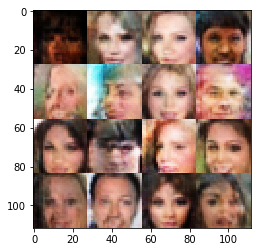

Epoch 2/2... Discriminator Loss: 1.4291... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.6926
Epoch 2/2... Discriminator Loss: 1.4626... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.4204... Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 1.4112... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.7461
Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 1.4312... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 1.4372... Generator Loss: 0.7201


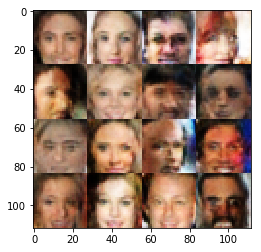

Epoch 2/2... Discriminator Loss: 1.4404... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.4506... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 1.4251... Generator Loss: 0.7364
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 1.4038... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.4340... Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 1.4391... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.7254
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.7615


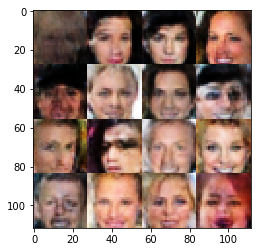

Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.7190
Epoch 2/2... Discriminator Loss: 1.4347... Generator Loss: 0.7014
Epoch 2/2... Discriminator Loss: 1.4285... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.7893


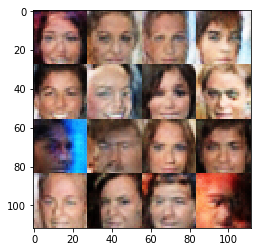

Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.7699
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.7269
Epoch 2/2... Discriminator Loss: 1.4175... Generator Loss: 0.7083
Epoch 2/2... Discriminator Loss: 1.4190... Generator Loss: 0.7530
Epoch 2/2... Discriminator Loss: 1.4333... Generator Loss: 0.6618
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.7520


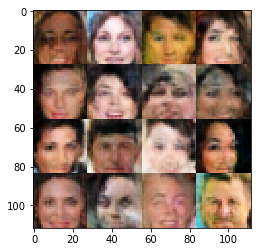

Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 1.4295... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.4259... Generator Loss: 0.7184
Epoch 2/2... Discriminator Loss: 1.4527... Generator Loss: 0.6781
Epoch 2/2... Discriminator Loss: 1.4294... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 1.4015... Generator Loss: 0.7718
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.7784
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.7386


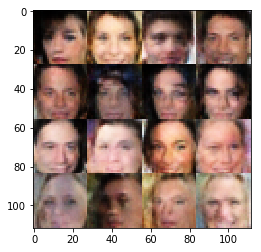

Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.4243... Generator Loss: 0.6658
Epoch 2/2... Discriminator Loss: 1.4317... Generator Loss: 0.7268
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 0.7950
Epoch 2/2... Discriminator Loss: 1.4317... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.7366
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.8103


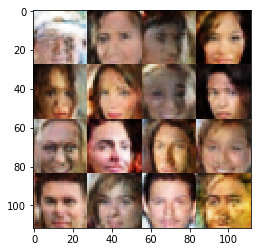

Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.4088... Generator Loss: 0.7267
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.6995


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.